# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow_text as text

In [4]:
!pip install -q tf-models-official

In [96]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 47.8 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 146 kB 65.5 MB/s 
     |████████████████████████████████| 112 kB 45.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=f1ab4dfc943696bffc90cc15c57e7ce2b745e9d6f3ff2b38976608df90ea7c9b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Imports

In [97]:
import numpy as np 
import pandas as pd 
import os
from os import listdir, getcwd, system
import datetime
import time
import timeit
from math import sqrt 
import pickle
import gc
import json
import re
import string


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf


# image
from PIL import Image
import kaleido

# Hy
pd.set_option('display.max_rows', 20) 

# Setup
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20,5)

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text

from official.nlp import optimization

from sklearn.model_selection import train_test_split

import optuna

In [6]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

## check runtime (gpu)

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul  7 22:19:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# tf.test.is_gpu_available()

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2996064045966623991
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14407172096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12366017725399304994
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Variables


In [12]:
folder = 'drive/MyDrive/Industrial_Applications_of_AI/Tertiary_Sector/HateSpeech'

# Load the training dataset 

In [13]:
df = pd.read_csv(os.path.join(folder,'labeled_data.csv'))
df = df.drop(['Unnamed: 0'], axis = 1)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [14]:
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
count,24783.00,3.24,0.88,3.00,3.00,3.00,3.00,9.00
hate_speech,24783.00,0.28,0.63,0.00,0.00,0.00,0.00,7.00
offensive_language,24783.00,2.41,1.40,0.00,2.00,3.00,3.00,9.00
neither,24783.00,0.55,1.11,0.00,0.00,0.00,0.00,9.00
class,24783.00,1.11,0.46,0.00,1.00,1.00,1.00,2.00


In [15]:
df.isnull().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

# Class distribution

In [16]:
px.histogram(df, x="class",
             histfunc='sum',
             height=400)


# Cleaning Text Data in Python

https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

In [17]:
df['tweet'].unique()

array(["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
       '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!',
       '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit',
       ...,
       'young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again',
       'youu got wild bitches tellin you lies',
       '~~Ruffled | Ntac Eileen Dahlia - Beautiful color combination of pink, orange, yellow &amp; white. A Coll http://t.co/H0dYEBvnZB'],
      dtype=object)

## Expand Contractions
Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words

In [18]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",'rt': '','RT':'',
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['tweets_prepared']=df['tweet'].apply(lambda x:expand_contractions(x))

In [19]:
df['tweets_prepared']

0        !!!  @mayasolovely: As a woman you should not ...
1        !!!!!  @mleew17: boy dats cold...tyga dwn bad ...
2        !!!!!!!  @UrKindOfBrand Dawg!!!!  @80sbaby4lif...
3        !!!!!!!!!  @C_G_Anderson: @viva_based she look...
4        !!!!!!!!!!!!!  @ShenikaRobes: The shit you hea...
                               ...                        
24778    you is a muthaf***in lie &#8220;@LifeAsKing: @...
24779    you have gone and broke the wrong hea baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweets_prepared, Length: 24783, dtype: object

## Lowercase the tweets

In [20]:
df['tweets_prepared']=df['tweets_prepared'].apply(lambda x: x.lower())

In [21]:
df['tweets_prepared']

0        !!!  @mayasolovely: as a woman you should not ...
1        !!!!!  @mleew17: boy dats cold...tyga dwn bad ...
2        !!!!!!!  @urkindofbrand dawg!!!!  @80sbaby4lif...
3        !!!!!!!!!  @c_g_anderson: @viva_based she look...
4        !!!!!!!!!!!!!  @shenikarobes: the shit you hea...
                               ...                        
24778    you is a muthaf***in lie &#8220;@lifeasking: @...
24779    you have gone and broke the wrong hea baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweets_prepared, Length: 24783, dtype: object

## Remove digits and words containing digits


In [22]:
df['tweets_prepared']=df['tweets_prepared'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['tweets_prepared']

0        !!!  @mayasolovely: as a woman you should not ...
1        !!!!!  @: boy dats cold...tyga dwn bad for cuf...
2        !!!!!!!  @urkindofbrand dawg!!!!  @: you ever ...
3        !!!!!!!!!  @c_g_anderson: @viva_based she look...
4        !!!!!!!!!!!!!  @shenikarobes: the shit you hea...
                               ...                        
24778    you is a muthaf***in lie &#;@lifeasking: @ @co...
24779    you have gone and broke the wrong hea baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweets_prepared, Length: 24783, dtype: object

## Remove Punctuations

In [23]:
df['tweets_prepared']=df['tweets_prepared'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Removing extra spaces
df['tweets_prepared']=df['tweets_prepared'].apply(lambda x: re.sub(' +',' ',x))

df['tweets_prepared']

0         mayasolovely as a woman you should not compla...
1         boy dats coldtyga dwn bad for cuffin dat hoe ...
2         urkindofbrand dawg you ever fuck a bitch and ...
3              cganderson vivabased she look like a tranny
4         shenikarobes the shit you hear about me might...
                               ...                        
24778    you is a muthafin lie lifeasking coreyemanuel ...
24779    you have gone and broke the wrong hea baby and...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweets_prepared, Length: 24783, dtype: object

# removal of stopwords and lemmatization

In [24]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['tweets_prepared']=df['tweets_prepared'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [25]:
df['tweets_prepared']

0          mayasolovely woman complain clean house amp ...
1            boy dat coldtyga dwn bad cuffin dat hoe place
2          urkindofbrand dawg fuck bitch sta cry confus...
3                     cganderson vivabase look like tranny
4           shenikarobe shit hear true faker bitch tell ya
                               ...                        
24778    muthafin lie lifeaske coreyemanuel right tl tr...
24779          go break wrong hea baby drive redneck crazy
24780    young buck wanna eat dat nigguh like be not fu...
24781                       youu get wild bitch tellin lie
24782    ruffle ntac eileen dahlia beautiful color comb...
Name: tweets_prepared, Length: 24783, dtype: object

# group them according to the class:



In [26]:
df

,count,hate_speech,offensive_language,neither,class,tweet,tweets_prepared
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely woman complain clean house amp ...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe place
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,urkindofbrand dawg fuck bitch sta cry confus...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,cganderson vivabase look like tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shenikarobe shit hear true faker bitch tell ya
...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthafin lie lifeaske coreyemanuel right tl tr...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",go break wrong hea baby drive redneck crazy
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like be not fu...
24781,6,0,6,0,1,youu got wild bitches tellin you lies,youu get wild bitch tellin lie


In [27]:
df_grouped=df.groupby(by='class').agg(lambda x:' '.join(x))
df_grouped.head()

,tweet,tweets_prepared
class,,
0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...",whalelookyhere queer gaywad whitethunduh a...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe plac...
2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely woman complain clean house amp ...


# Wordcloud

https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

In [28]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [29]:
class_0 = df[df['class']==0]['tweets_prepared']
class_1 = df[df['class']==2]['tweets_prepared']
class_2 = df[df['class']==1]['tweets_prepared']

In [30]:
class_0

85                             whalelookyhere queer gaywad
89         whitethunduh alsarabsss s beaner smh tell s ...
110      devilgrimz vigxra fuck gay blacklisted hoe hol...
184      markroundtreejr lmfaoooo hate black people htt...
202                   nochillpaz nigger httptco \n\n lmfao
                               ...                        
24576                                  guy big faggot omfg
24685    name offensive kike wop kraut wetback jigaboo ...
24751                           pussy ass nigga know nigga
24776                                               nigger
24777    retard hope type diabetes die sugar rush fuck ...
Name: tweets_prepared, Length: 1430, dtype: object

In [31]:
class_0_text = text = ' '.join(class_0).lower()
class_2_text = text = ' '.join(class_1).lower()
class_1_text = text = ' '.join(class_2).lower()

In [32]:
class_0_text

'  whalelookyhere queer gaywad   whitethunduh alsarabsss s beaner smh tell s mexican devilgrimz vigxra fuck gay blacklisted hoe hold tehgodclan httptcoxuccwoetmn markroundtreejr lmfaoooo hate black people httpstco black people nigger nochillpaz nigger httptco \n\n lmfao   whiteponyjr ariza snake coward cripple like hero roach lmaoo nba drake new shoe release nikejordan yes glitter shoe httptcoqctplxhexm dude fag theomaxximus gerryshalloweenpay httptco halloween yesterday stupid nigger ashlingwilde itsnotadam bore suppose cute faggot bigbootybishopp whitethunduh lassen cc coach want feel ll nig doubt jayswaggkillah jackie retard blondeproblem grill cheese jgabsss stacey dash win httptco badd bitch evaaaa not worry nigga worry nigga not dat da nigga fuckin yo bitch hey look video man find kidnap girl ohiowhat nigger shitmybosssay let kill cracker baby wtf hear wow grandma porch monkey time come think refer broken bottle nigg knife nah nomeekjustmilz yo think photoshoppe face faggot smmfh

## wordcloud class = 0 - hate speech 

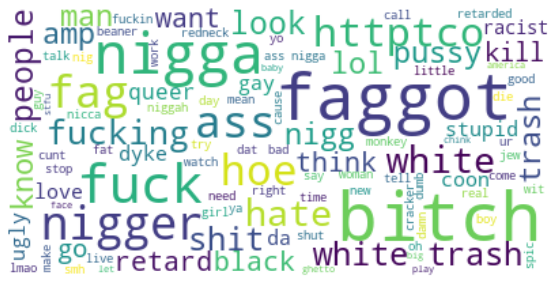

In [33]:
class_0
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(class_0_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

 ## wordcloud class = 1 - offensive language

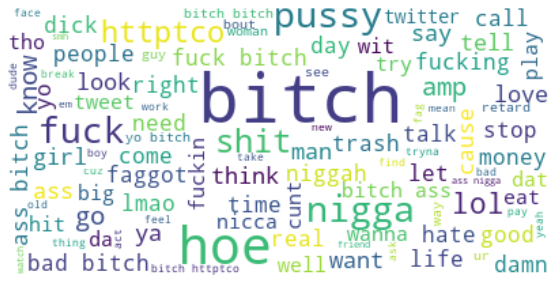

In [34]:
class_0
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(class_1_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

 ## wordcloud class = 2 - neither hate speech nor offensive language

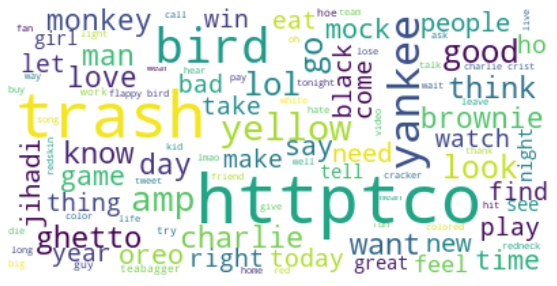

In [35]:
class_0
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(class_2_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# More Data exploration


## How many words per tweet per class?

In [36]:
df['tweets_prepared'][0]

'  mayasolovely woman complain clean house amp man trash'

In [37]:
df['tweets_prepared'][0].split()

['mayasolovely', 'woman', 'complain', 'clean', 'house', 'amp', 'man', 'trash']

In [38]:
len(df['tweets_prepared'][0].split())

8

In [39]:
df['tweets_number_of_words'] = [len(word.split()) for word in df['tweets_prepared']]

In [40]:
df['tweets_number_of_words'][0]

8

In [41]:
class_0 = np.sort(df[df['class']==0]['tweets_number_of_words'])
class_1 = np.sort(df[df['class']==2]['tweets_number_of_words'])
class_2 = np.sort(df[df['class']==1]['tweets_number_of_words'])

In [42]:
px.bar(class_0, title ='Number of words per tweet for class = 0 (hate speech)')

In [43]:
px.bar(class_1, title ='Number of words per tweet for class = 1 (offensive language)')

In [44]:
px.bar(class_2, title ='Number of words per tweet for class = 2 (neither hate speech nor offensive language)')

In [45]:
for i, class_i in enumerate([class_0, class_1, class_2]):
  print('Class:',i,'average number of words',np.average(class_i))

Class: 0 average number of words 7.7027972027972025
Class: 1 average number of words 8.234686524141244
Class: 2 average number of words 7.311724856696196


Tweets with offensive language are on average longer than others

# Which words are often used most often in which type of tweet

In [46]:
from collections import Counter
class_0_counter_words = dict(Counter(class_0_text.split()))

In [47]:
class_0_counter_words_sorted = dict(sorted(class_0_counter_words.items(), key=lambda item: item[1]))

In [48]:
px.bar(x=class_0_counter_words_sorted.keys(), y=class_0_counter_words_sorted.values(), title = 'Counting of occurence of words in class = 0 (hate speech)<br>You need to zoom in')

In [49]:
class_1_counter_words = dict(Counter(class_1_text.split()))
class_1_counter_words_sorted = dict(sorted(class_1_counter_words.items(), key=lambda item: item[1]))
px.bar(x=class_1_counter_words_sorted.keys(), y=class_1_counter_words_sorted.values(), title = 'Counting of occurence of words in class = 1 (offensive language)<br>You need to zoom in')

In [50]:
class_2_counter_words = dict(Counter(class_2_text.split()))

class_2_counter_words_sorted = dict(sorted(class_2_counter_words.items(), key=lambda item: item[1]))
px.bar(x=class_2_counter_words_sorted.keys(), y=class_2_counter_words_sorted.values(), title = 'Counting of occurence of words in class = 2 (neither hate speech nor offensive language)<br>You need to zoom in')

In [51]:
# simplitfy the class label
# if hate speech or offensive language class_simplified = 1, else class_simplified = 0
def return_class(input_class):
  if input_class == 2:
    return 0
  else:
    return 1


df['class_simplified'] = [return_class(input_class) for input_class in df['class']]

In [52]:
df[['tweet','class','class_simplified']][:40]

,tweet,class,class_simplified
0,!!! RT @mayasolovely: As a woman you shouldn't...,2,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,1
...,...,...,...
35,""" is that ya bitch """,1,1
36,""" it aint nothing to cut a bitch off """,1,1
37,""" jus meet son now he ya mane ass bitches "" #S...",1,1
38,""" lames crying over hoes thats tears of a clown """,1,1


# Train classifier to predict class

# BERT

# Data preparation

In [53]:
#Doing some renaming
print(df.columns)
df_full = df

# df = df.drop('data_type', axis=1)

#class_simplified to label
#tweets_prepared to text

df.columns = ['count', 'hate_speech', 'offensive_language', 'neither', 'class',
      'tweet', 'text', 'tweets_number_of_words',
      'label']
print(df.columns)

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet', 'tweets_prepared', 'tweets_number_of_words',
       'class_simplified'],
      dtype='object')
Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet', 'text', 'tweets_number_of_words', 'label'],
      dtype='object')


## undersampling

In [54]:
df_0 = df[df['label']==0]
df_1 = df[df['label']==1]
print(len(df_0), len(df_1) )

4163 20620


In [55]:
df_1 = df_1.sample(len(df_0))

In [56]:
print(len(df_0), len(df_1) )

4163 4163


In [57]:
df = df_0.append(df_1)

In [58]:
print(len(df))

8326


In [59]:
# resample df
df = df.sample(frac=1).reset_index(drop=True)


In [60]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,text,tweets_number_of_words,label
0,3,0,2,1,1,"RT @HennyHeathen: Bitches eat mad beef,drink H...",hennyheathen bitch eat mad beefdrink henny s...,10,1
1,3,1,2,0,1,When Jake was mad happy and hugged muscle face...,jake mad happy hug muscle face renee russo end...,14,1
2,3,2,0,1,0,@Nien_Nunb what did you search? Gay redneck ep...,niennunb search gay redneck episode play,6,1
3,3,0,3,0,1,RT @NewLegendaryEra: Twitter gives bitches unr...,newlegendaryera twitter give bitch unrealist...,12,1
4,3,0,0,3,2,RT @JohnnyFootbalI: Yeah Kaepernick might have...,johnnyfootbali yeah kaepernick bicep like gr...,14,0


# Data Splitting

In [61]:
df_y = df['label']
df_X = df.drop('label',  axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X,df_y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [62]:
X_train

,count,hate_speech,offensive_language,neither,class,tweet,text,tweets_number_of_words
4190,3,0,1,2,2,@ThatGuyNorman @migue_pantoja trash,thatguynorman miguepantoja trash,3
5489,3,1,2,0,1,@BobbyBotsods @FuckTheMallcops @UncleUnco @MrM...,bobbybotsod fuckthemallcop uncleunco mrmooncri...,8
1576,3,0,0,3,2,@CapitolEVAN That's where I saw the leprechaun...,capitolevan see leprechaun tell burn thing,6
7961,3,0,2,1,1,"Just smoked a whole 8th of that Reserve, thank...",smoke reserve thank niggah,4
5404,3,0,0,3,2,"Sometimes I wish I had a cute pet monkey, but ...",wish cute pet monkey remember probably defecat...,10
...,...,...,...,...,...,...,...,...
7086,3,0,1,2,2,RT @Jakelewis44_: We don't luv deez hoes&#1285...,luv deez hoe httptco,4
247,3,1,0,2,2,Disturbing: feeling pressure from #ISIS fanboy...,disturb feeling pressure isis fanboy al qaeda ...,14
1778,3,0,0,3,2,RT @NFLonFOX: Palmer to Fitzgerald - TOUCHDOWN...,nflonfox palmer fitzgerald touchdown \n\n ya...,11
2634,3,0,3,0,1,RT @ogkels_: brought to you by bad bitches and...,ogkel bring bad bitch good weed,6


## save text files to directory to us in tf.keras.utils.text_dataset_from_directory

https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory

In [63]:
for selected_folder, selected_X, selected_y in zip(['train', 'val','test'], [X_train, X_val, X_test], [y_train, y_val, y_test]):
  
  save_folder =os.path.join(folder,'Dataset_BERT_preperation',selected_folder)
  

  for i, (selected_text_X, selected_entry_y) in enumerate(zip(selected_X.text, selected_y)):
    print('label', selected_entry_y)
    print('text', selected_text_X)

    save_path = os.path.join(save_folder, str(selected_entry_y),'{}.txt'.format(i))
    print(save_path)
    print()
    with open(save_path, 'w') as f:
      f.write(selected_text_X)

Streaming output truncated to the last 5000 lines.

label 1
text comin fat bitch
drive/MyDrive/Industrial_Applications_of_AI/Tertiary_Sector/HateSpeech/Dataset_BERT_preperation/test/1/461.txt

label 1
text ruley bitch ry
drive/MyDrive/Industrial_Applications_of_AI/Tertiary_Sector/HateSpeech/Dataset_BERT_preperation/test/1/462.txt

label 0
text kingsm howard elbow bosh bosh fight got mcbob bird ud
drive/MyDrive/Industrial_Applications_of_AI/Tertiary_Sector/HateSpeech/Dataset_BERT_preperation/test/0/463.txt

label 1
text m prolly wit yo bitch big butt not fit
drive/MyDrive/Industrial_Applications_of_AI/Tertiary_Sector/HateSpeech/Dataset_BERT_preperation/test/1/464.txt

label 1
text lock bitch heat msmarrie shut door
drive/MyDrive/Industrial_Applications_of_AI/Tertiary_Sector/HateSpeech/Dataset_BERT_preperation/test/1/465.txt

label 0
text   marywcvb charlie baker final election eve campaign stop swampscott high school wcvb wcvbpoli httptco
drive/MyDrive/Industrial_Applications_of_AI/Tert

# Create Flow from directory

In [64]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

Dataset_BERT_preperation_train_folder = os.path.join(folder, 'Dataset_BERT_preperation', 'train')
Dataset_BERT_preperation_val_folder = os.path.join(folder, 'Dataset_BERT_preperation', 'val')
Dataset_BERT_preperation_test_folder = os.path.join(folder, 'Dataset_BERT_preperation', 'test')

In [65]:
os.listdir(Dataset_BERT_preperation_train_folder)

['1', '0']

In [66]:
# create the generators that take the data from the directory
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    Dataset_BERT_preperation_val_folder,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    Dataset_BERT_preperation_train_folder,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


test_ds = tf.keras.utils.text_dataset_from_directory(
    Dataset_BERT_preperation_test_folder,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1751 files belonging to 2 classes.
Using 1401 files for training.
Found 5249 files belonging to 2 classes.
Using 1049 files for validation.
Found 1742 files belonging to 2 classes.


Let's take a look at a few tweets.

In [67]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b's pop m dog like stewie griffin bitch hear like ooh rippin'
Label : 1 (1)
Review: b'jaaaaaade shut miss fag'
Label : 1 (1)
Review: b'love everybody bitch heat fan win lose hater obnoxious'
Label : 1 (1)


https://www.tensorflow.org/text/tutorials/classify_text_with_bert

# Loading models from TensorFlow Hub

https://www.kaggle.com/code/sceeptex/hate-speech-bert-cnn-and-bert-mlp-in-tensorflow/edit

In [68]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' # does not work
# bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
# bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


### The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library. Hence, It is not necessary to run pure Python code outside the TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which can be read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically. https://www.kaggle.com/code/giovanimachado/hate-speech-bert-cnn-and-bert-mlp-in-tensorflow

In [69]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [70]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

# Preprocessing for BERT

In [71]:
text_test = ['this is such an amazing movie!']


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


# Define Model BERT + NN

In [88]:
def build_classifier_model():
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [89]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)


# Training

In [90]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()


In [91]:
epochs = 40
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-7
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [92]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [93]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/40
44/44 [==============================] - 23s 308ms/step - loss: 0.7824 - binary_accuracy: 0.5132 - val_loss: 0.7885 - val_binary_accuracy: 0.5262
Epoch 2/40
44/44 [==============================] - 13s 296ms/step - loss: 0.7703 - binary_accuracy: 0.5132 - val_loss: 0.7482 - val_binary_accuracy: 0.5262
Epoch 3/40
44/44 [==============================] - 13s 294ms/step - loss: 0.7328 - binary_accuracy: 0.5132 - val_loss: 0.7029 - val_binary_accuracy: 0.5262
Epoch 4/40
44/44 [==============================] - 13s 308ms/step - loss: 0.6864 - binary_accuracy: 0.5132 - val_loss: 0.6641 - val_binary_accuracy: 0.5262
Epoch 5/40
44/44 [==============================] - 13s 293ms/step - loss: 0.6576 - binary_accuracy: 0.5132 - val_loss: 0.6320 - val_binary_accuracy: 0.5262
Epoch 6/40
44/44 [==============================] - 13s 290ms/step - loss: 0.6368 - binary_accuracy: 0.5132 - val_loss: 0.6

KeyboardInterrupt: ignored

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

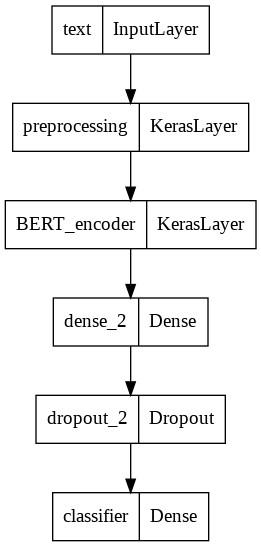

In [98]:
print(classifier_model.summary())
tf.keras.utils.plot_model(classifier_model)

### Evaluate the model

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# try out several lr and epochs:

In [99]:


# 1. Define an objective function to be maximized.
def objective(trial):
  classifier_model = build_classifier_model()
  bert_raw_result = classifier_model(tf.constant(text_test))
  print(tf.sigmoid(bert_raw_result))

  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()

  epochs = trial.suggest_int("epochs", 5, 50)
  steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  init_lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')


  classifier_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)

  print(f'Training model with {tfhub_handle_encoder}')
  history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)
  
  print('Testing')
  loss, accuracy = classifier_model.evaluate(test_ds)

  print(f'Loss: {loss}')
  print(f'Accuracy: {accuracy}')

  return accuracy


In [100]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2022-07-07 22:40:31,019] A new study created in memory with name: no-name-c1b0212f-35f9-4b70-b3e3-2508fde8ed5e


tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/35
44/44 [==============================] - 54s 303ms/step - loss: 1.3960 - binary_accuracy: 0.5132 - val_loss: 0.6968 - val_binary_accuracy: 0.5262
Epoch 2/35
44/44 [==============================] - 13s 288ms/step - loss: 0.7238 - binary_accuracy: 0.5132 - val_loss: 0.6927 - val_binary_accuracy: 0.5262
Epoch 3/35
44/44 [==============================] - 13s 290ms/step - loss: 0.6959 - binary_accuracy: 0.5132 - val_loss: 0.6951 - val_binary_accuracy: 0.5262
Epoch 4/35
44/44 [==============================] - 13s 307ms/step - loss: 0.6968 - binary_accuracy: 0.5132 - val_loss: 0.6955 - val_binary_accuracy: 0.5262
Epoch 5/35
44/44 [==============================] - 13s 295ms/step - loss: 0.6966 - binary_accuracy: 0.5132 - val_loss: 0.6957 - val_binary_accuracy: 0.5262
Epoch 6/35
44/44 [==============================] - 13s 292ms/step -

[I 2022-07-07 22:49:43,501] Trial 0 finished with value: 0.49712973833084106 and parameters: {'epochs': 35, 'lr': 0.05914777595011616}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.6936883330345154
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/22
44/44 [==============================] - 21s 307ms/step - loss: 0.5258 - binary_accuracy: 0.5132 - val_loss: 0.3046 - val_binary_accuracy: 0.5262
Epoch 2/22
44/44 [==============================] - 13s 289ms/step - loss: 1.0772 - binary_accuracy: 0.5132 - val_loss: 0.7741 - val_binary_accuracy: 0.5262
Epoch 3/22
44/44 [==============================] - 13s 294ms/step - loss: 0.7423 - binary_accuracy: 0.5132 - val_loss: 0.6953 - val_binary_accuracy: 0.5262
Epoch 4/22
44/44 [==============================] - 13s 294ms/step - loss: 0.6959 - binary_accuracy: 0.5132 - val_loss: 0.6923 - val_binary_accuracy: 0.5262
Epoch 5/22
44/44 [==============================] - 13s 294ms/step - loss: 0.6946 - binary_accuracy: 0.5132 - val_loss: 0.6929 - val_binary_accuracy: 0.5262
Epoch 6/22
44

[I 2022-07-07 22:55:00,189] Trial 1 finished with value: 0.49712973833084106 and parameters: {'epochs': 22, 'lr': 0.004439945432871992}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.6937984824180603
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/7
44/44 [==============================] - 21s 308ms/step - loss: 0.5911 - binary_accuracy: 0.5132 - val_loss: 0.9831 - val_binary_accuracy: 0.5262
Epoch 2/7
44/44 [==============================] - 13s 292ms/step - loss: 0.5823 - binary_accuracy: 0.5132 - val_loss: 0.5553 - val_binary_accuracy: 0.5262
Epoch 3/7
44/44 [==============================] - 13s 292ms/step - loss: 0.5022 - binary_accuracy: 0.5132 - val_loss: 0.5380 - val_binary_accuracy: 0.5262
Epoch 4/7
44/44 [==============================] - 13s 289ms/step - loss: 0.6167 - binary_accuracy: 0.5132 - val_loss: 0.7483 - val_binary_accuracy: 0.5262
Epoch 5/7
44/44 [==============================] - 13s 292ms/step - loss: 0.7123 - binary_accuracy: 0.5132 - val_loss: 0.6828 - val_binary_accuracy: 0.5262
Epoch 6/7
44/44 [=

[I 2022-07-07 22:56:59,629] Trial 2 finished with value: 0.49712973833084106 and parameters: {'epochs': 7, 'lr': 0.00294138241955404}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.6882069706916809
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/14
44/44 [==============================] - 19s 303ms/step - loss: 0.4892 - binary_accuracy: 0.5132 - val_loss: 0.2393 - val_binary_accuracy: 0.5262
Epoch 2/14
44/44 [==============================] - 13s 288ms/step - loss: 0.1941 - binary_accuracy: 0.5132 - val_loss: 0.2412 - val_binary_accuracy: 0.5262
Epoch 3/14
44/44 [==============================] - 13s 290ms/step - loss: 0.0972 - binary_accuracy: 0.5132 - val_loss: 0.3692 - val_binary_accuracy: 0.5262
Epoch 4/14
44/44 [==============================] - 13s 297ms/step - loss: 0.0681 - binary_accuracy: 0.5132 - val_loss: 0.2963 - val_binary_accuracy: 0.5262
Epoch 5/14
44/44 [==============================] - 13s 291ms/step - loss: 0.0540 - binary_accuracy: 0.5132 - val_loss: 0.4046 - val_binary_accuracy: 0.5262
Epoch 6/14
44

[I 2022-07-07 23:00:26,702] Trial 3 finished with value: 0.49712973833084106 and parameters: {'epochs': 14, 'lr': 0.00038144848055922663}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.516163170337677
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/8
44/44 [==============================] - 21s 306ms/step - loss: 0.6509 - binary_accuracy: 0.5132 - val_loss: 0.4339 - val_binary_accuracy: 0.5262
Epoch 2/8
44/44 [==============================] - 13s 293ms/step - loss: 0.3618 - binary_accuracy: 0.5132 - val_loss: 0.2881 - val_binary_accuracy: 0.5262
Epoch 3/8
44/44 [==============================] - 13s 292ms/step - loss: 0.2260 - binary_accuracy: 0.5132 - val_loss: 0.2691 - val_binary_accuracy: 0.5262
Epoch 4/8
44/44 [==============================] - 13s 291ms/step - loss: 0.1697 - binary_accuracy: 0.5132 - val_loss: 0.2496 - val_binary_accuracy: 0.5262
Epoch 5/8
44/44 [==============================] - 13s 291ms/step - loss: 0.1356 - binary_accuracy: 0.5132 - val_loss: 0.2419 - val_binary_accuracy: 0.5262
Epoch 6/8
44/44 [==

[I 2022-07-07 23:02:41,080] Trial 4 finished with value: 0.49712973833084106 and parameters: {'epochs': 8, 'lr': 1.9229066126002015e-05}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.22004403173923492
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/35
44/44 [==============================] - 22s 307ms/step - loss: 0.6808 - binary_accuracy: 0.5132 - val_loss: 0.5053 - val_binary_accuracy: 0.5262
Epoch 2/35
44/44 [==============================] - 13s 292ms/step - loss: 0.3778 - binary_accuracy: 0.5132 - val_loss: 0.2548 - val_binary_accuracy: 0.5262
Epoch 3/35
44/44 [==============================] - 13s 292ms/step - loss: 0.1767 - binary_accuracy: 0.5132 - val_loss: 0.2216 - val_binary_accuracy: 0.5262
Epoch 4/35
44/44 [==============================] - 13s 292ms/step - loss: 0.0863 - binary_accuracy: 0.5132 - val_loss: 0.3580 - val_binary_accuracy: 0.5262
Epoch 5/35
44/44 [==============================] - 14s 309ms/step - loss: 0.0583 - binary_accuracy: 0.5132 - val_loss: 0.3288 - val_binary_accuracy: 0.5262
Epoch 6/35
4

[I 2022-07-07 23:11:05,376] Trial 5 finished with value: 0.49712973833084106 and parameters: {'epochs': 35, 'lr': 8.085458289122047e-05}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.5402779579162598
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/12
44/44 [==============================] - 20s 313ms/step - loss: 1.2184 - binary_accuracy: 0.5132 - val_loss: 0.7123 - val_binary_accuracy: 0.5262
Epoch 2/12
44/44 [==============================] - 13s 293ms/step - loss: 0.7008 - binary_accuracy: 0.5132 - val_loss: 0.6948 - val_binary_accuracy: 0.5262
Epoch 3/12
44/44 [==============================] - 13s 294ms/step - loss: 0.6953 - binary_accuracy: 0.5132 - val_loss: 0.6942 - val_binary_accuracy: 0.5262
Epoch 4/12
44/44 [==============================] - 13s 290ms/step - loss: 0.6948 - binary_accuracy: 0.5132 - val_loss: 0.6936 - val_binary_accuracy: 0.5262
Epoch 5/12
44/44 [==============================] - 13s 302ms/step - loss: 0.6945 - binary_accuracy: 0.5132 - val_loss: 0.6933 - val_binary_accuracy: 0.5262
Epoch 6/12
44

[I 2022-07-07 23:14:31,359] Trial 6 finished with value: 0.49712973833084106 and parameters: {'epochs': 12, 'lr': 0.042891876470146924}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.6936880946159363
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/34
44/44 [==============================] - 21s 306ms/step - loss: 0.4722 - binary_accuracy: 0.5132 - val_loss: 0.3084 - val_binary_accuracy: 0.5262
Epoch 2/34
44/44 [==============================] - 13s 292ms/step - loss: 0.2608 - binary_accuracy: 0.5132 - val_loss: 0.3394 - val_binary_accuracy: 0.5262
Epoch 3/34
44/44 [==============================] - 13s 294ms/step - loss: 0.3666 - binary_accuracy: 0.5132 - val_loss: 0.3553 - val_binary_accuracy: 0.5262
Epoch 4/34
44/44 [==============================] - 13s 290ms/step - loss: 0.7951 - binary_accuracy: 0.5132 - val_loss: 0.7515 - val_binary_accuracy: 0.5262
Epoch 5/34
44/44 [==============================] - 13s 291ms/step - loss: 0.7463 - binary_accuracy: 0.5132 - val_loss: 0.8121 - val_binary_accuracy: 0.5262
Epoch 6/34
44

[I 2022-07-07 23:22:16,182] Trial 7 finished with value: 0.49712973833084106 and parameters: {'epochs': 34, 'lr': 0.001449407008439132}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.6935972571372986
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/15
44/44 [==============================] - 20s 311ms/step - loss: 0.6533 - binary_accuracy: 0.5132 - val_loss: 0.4367 - val_binary_accuracy: 0.5262
Epoch 2/15
44/44 [==============================] - 13s 297ms/step - loss: 1.3547 - binary_accuracy: 0.5132 - val_loss: 0.6967 - val_binary_accuracy: 0.5262
Epoch 3/15
44/44 [==============================] - 13s 304ms/step - loss: 0.9504 - binary_accuracy: 0.5132 - val_loss: 0.6990 - val_binary_accuracy: 0.5262
Epoch 4/15
44/44 [==============================] - 13s 298ms/step - loss: 0.6965 - binary_accuracy: 0.5132 - val_loss: 0.6939 - val_binary_accuracy: 0.5262
Epoch 5/15
44/44 [==============================] - 13s 297ms/step - loss: 0.6935 - binary_accuracy: 0.5132 - val_loss: 0.6926 - val_binary_accuracy: 0.5262
Epoch 6/15
44

[I 2022-07-07 23:25:51,782] Trial 8 finished with value: 0.49712973833084106 and parameters: {'epochs': 15, 'lr': 0.00661452240661221}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.6936817169189453
Accuracy: 0.49712973833084106
tf.Tensor([[0.73105854]], shape=(1, 1), dtype=float32)
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/11
44/44 [==============================] - 22s 305ms/step - loss: 0.5558 - binary_accuracy: 0.5132 - val_loss: 0.3039 - val_binary_accuracy: 0.5262
Epoch 2/11
44/44 [==============================] - 13s 290ms/step - loss: 0.2178 - binary_accuracy: 0.5132 - val_loss: 0.2146 - val_binary_accuracy: 0.5262
Epoch 3/11
44/44 [==============================] - 13s 291ms/step - loss: 0.1168 - binary_accuracy: 0.5132 - val_loss: 0.2248 - val_binary_accuracy: 0.5262
Epoch 4/11
44/44 [==============================] - 13s 291ms/step - loss: 0.0605 - binary_accuracy: 0.5132 - val_loss: 0.3899 - val_binary_accuracy: 0.5262
Epoch 5/11
44/44 [==============================] - 13s 289ms/step - loss: 0.0197 - binary_accuracy: 0.5132 - val_loss: 0.5317 - val_binary_accuracy: 0.5262
Epoch 6/11
44

[I 2022-07-07 23:28:54,960] Trial 9 finished with value: 0.49712973833084106 and parameters: {'epochs': 11, 'lr': 9.684275324468058e-05}. Best is trial 0 with value: 0.49712973833084106.


Loss: 0.4661974310874939
Accuracy: 0.49712973833084106
